In [37]:
#Import Libs.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn import metrics
import itertools

%matplotlib inline

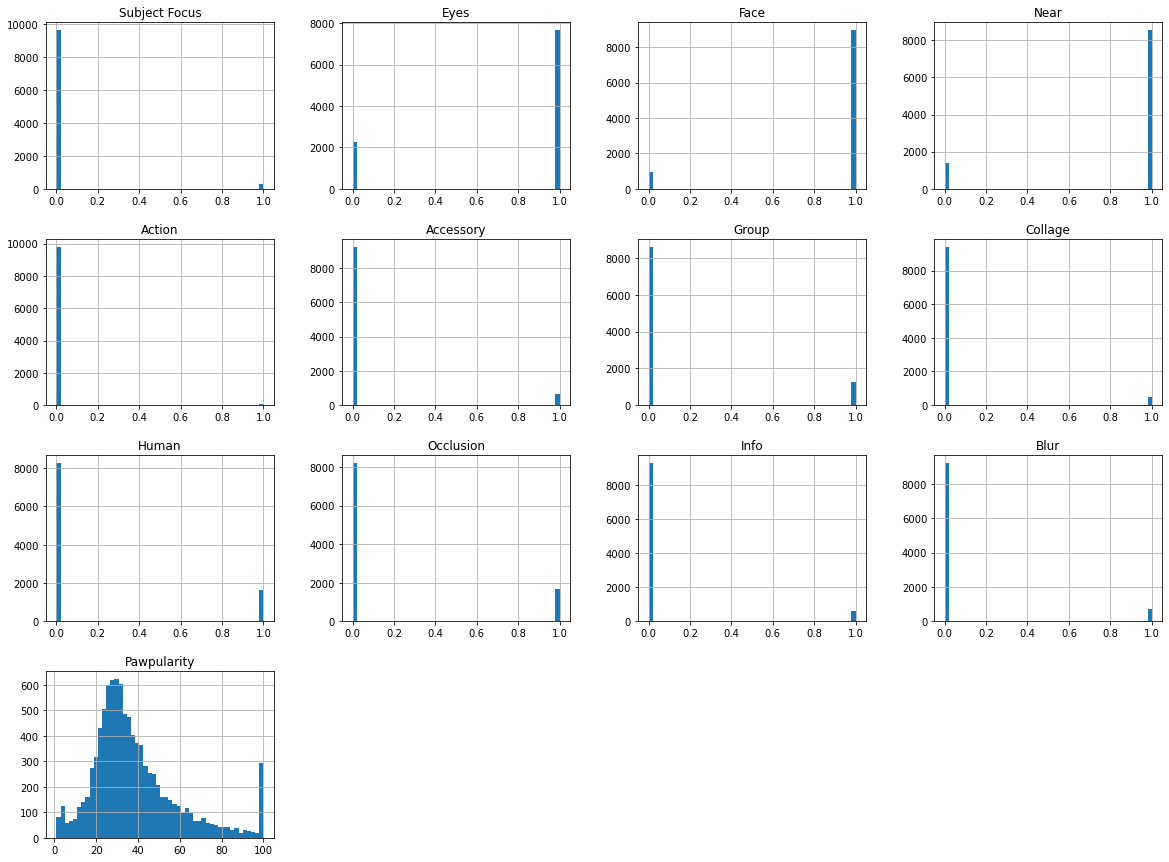

In [38]:
paw_train = pd.read_csv('https://github.com/Pedro3141/Pawpularity/raw/main/train.csv')
# Plot Data
paw_train.hist(bins=50,figsize=(20,15))
plt.show()

In [39]:
paw_train['Pawpularity'].describe()
# mean: 38.04, std: 20.59

count    9912.000000
mean       38.039044
std        20.591990
min         1.000000
25%        25.000000
50%        33.000000
75%        46.000000
max       100.000000
Name: Pawpularity, dtype: float64

In [40]:
paw_matrix = paw_train.corr()
paw_matrix['Pawpularity'].sort_values(ascending=False)
# Group, Accessory, and Face have strong Corralation

Pawpularity      1.000000
Group            0.016469
Accessory        0.013287
Face             0.008018
Human            0.003983
Occlusion        0.001979
Collage          0.001732
Near             0.001001
Action          -0.001373
Info            -0.004735
Eyes            -0.006686
Subject Focus   -0.009853
Blur            -0.023540
Name: Pawpularity, dtype: float64

In [41]:
#feature_cols = ['Group']
feature_cols = ['Subject Focus','Eyes','Face','Near','Action','Accessory','Group','Collage','Human','Occlusion','Info','Blur']
X = paw_train[feature_cols]
y = paw_train['Pawpularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=6)

In [42]:
#Log. Reg using Train Test Split and all 12 Features
my_linreg = LinearRegression()
my_linreg.fit(X_train, y_train)

LinearRegression()

In [43]:
# Print intercept and coef of the Lin. Reg
print(my_linreg.intercept_)
print(my_linreg.coef_)

37.32242826629845
[-2.46177616 -4.38998163  3.57919146  1.2512897   0.4187078   0.23616999
  1.53588176  0.30095964  1.10229038 -1.4014051  -0.39532514 -4.19453837]


In [44]:
# Calc RMSE
y_prediction = my_linreg.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_prediction)
rmse = np.sqrt(mse)
print(rmse)

20.628257900987727


In [45]:
# make predictions on the testing set
y_prediction = my_linreg.predict(X_test)
print(y_prediction)

[37.76292779 37.65403964 37.76292779 ... 37.76292779 37.76292779
 37.76292779]


In [46]:
# Dimensionality Reduction using PCA
my_pca = PCA(n_components=4)
X_train_new = my_pca.fit_transform(X_train)
X_test_new = my_pca.fit_transform(X_test)

In [47]:
pca_reg = LinearRegression()
pca_reg.fit(X_train_new,y_train)
print(pca_reg.intercept_)
print(pca_reg.coef_)
y_predict_new = pca_reg.predict(X_test_new)
# Calc. RMSE
mse = metrics.mean_squared_error(y_test, y_predict_new)
rmse = np.sqrt(mse)
print(rmse)

38.04254245838238
[ 0.93639133  0.1615229  -0.37960934 -1.48757628]
20.59934184732713


In [48]:
# Find each combination
all_combinations = []
for r in range(len(feature_cols) + 1):
    combinations_object = itertools.combinations(feature_cols, r)
    combinations_list = list(combinations_object)
    all_combinations += combinations_list   
print(len(all_combinations))

4096


In [49]:
results_lst = []
#Convert into list rather than tuples for pandas to work
combinations = [list(ele) for ele in all_combinations]
# 0 empty
# 1-12 Single Feature

#Lin. Reg using Train Test Split
for combo in combinations[1:]:
    combo_reg = LinearRegression()
    X = paw_train[combo]
    y = paw_train['Pawpularity']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=6)
    combo_reg.fit(X_train,y_train)
    inter = combo_reg.intercept_
    coef = combo_reg.coef_
    y_predict = combo_reg.predict(X_test)
    mse = metrics.mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(mse)
    #results_lst.append((combo,coef,inter,rmse))#(Features,coef,inter,rmse)
    results_lst.append((combo,rmse))
    #print(combo,inter,rmse,sep=': ')


In [50]:
print("Min RMSE using Train-Test-Split", min(results_lst, key=lambda tuple:tuple[1]))
print("Max RMSE using Train-Test-Split", max(results_lst, key=lambda tuple:tuple[1]))

Min RMSE using Train-Test-Split (['Face', 'Accessory', 'Group', 'Human', 'Info', 'Blur'], 20.556024486738178)
Max RMSE using Train-Test-Split (['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Group', 'Collage', 'Human', 'Occlusion'], 20.639902720353476)


In [51]:
from sklearn.model_selection import cross_val_score
cv_list = []
#Lin. Reg using 10-fold Cross Validation
#combinations is a list of all possible feature matrix combinations

# 0 empty
# 1-12 Single Feature
for combo in combinations[12:]:
    my_linreg = LinearRegression()
    mse_list = cross_val_score(my_linreg, paw_train[combo], y, cv=10, 
                               scoring='neg_mean_squared_error')
    rmse_list = np.sqrt(-mse_list)
    rmse = rmse_list.mean()
    cv_list.append((combo,rmse))#(Features,rmse)
    #print(combo,rmse,sep=': ')




In [52]:
print("Min RMSE using 10-fold CV", min(cv_list, key=lambda tuple:tuple[1]))
print("Max RMSE using 10-fold CV", max(cv_list, key=lambda tuple:tuple[1]))

Min RMSE using 10-fold CV (['Eyes', 'Face', 'Accessory', 'Group', 'Blur'], 20.573714438541003)
Max RMSE using 10-fold CV (['Subject Focus', 'Eyes', 'Near', 'Action', 'Collage', 'Human', 'Occlusion', 'Info'], 20.60204865390371)
